# Simple Moving Average

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

Consider the Tesla stock of the latest 90 days.

In [5]:
stocks: pd.DataFrame = pd.read_csv("../../data/stocks.csv", index_col=0, parse_dates=True)
company = "TSLA"
stock = stocks.query(f"Company == '{company}'").drop(columns=["Company", "Sector"])
stock_price = stock[["Close"]]
stock_price

,Close
Date,
2017-11-02,19.950666
2017-11-03,20.406000
2017-11-06,20.185333
2017-11-07,20.403334
2017-11-08,20.292667
...,...
2022-10-26,224.639999
2022-10-27,225.089996
2022-10-28,228.520004


## Long and Short-Term Simple Moving Averages

For each day, we need to compute the average stock price within a period of time before that day. To do so, we need to *slide* a fixed length window (hence the name *moving* average) along the times series and compute the mean value of the prices falling into the window. Panda's `DataFrame` (or `Series`) has a method `rolling`, which can achieve this easily.

In this notebook, we assume the periods of the long and short-term SMA are 20 and 5, respectively. We now compute the moving averages:

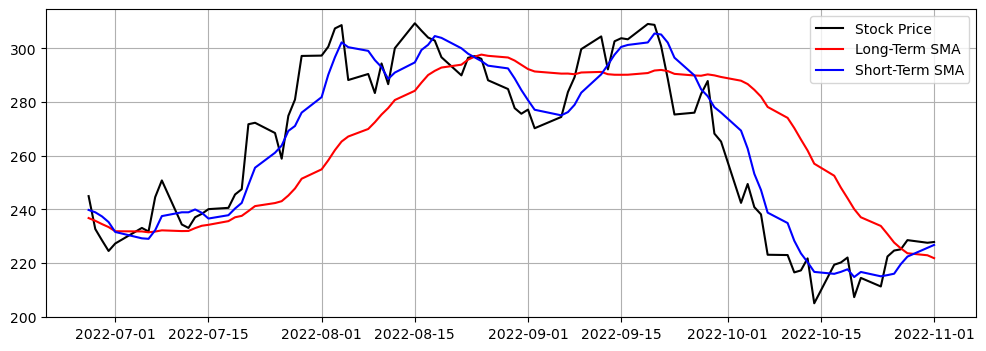

In [6]:
long_period = 20
short_period = 5

long = stock_price.rolling(long_period).mean()
short = stock_price.rolling(short_period).mean()

# plot stock price, long-term SMA and short-term SMA of the last 90 days
num_days = 90
plt.figure(figsize=(12, 4))
plt.plot(stock_price[-num_days:], label="Stock Price", color="k")
plt.plot(long[-num_days:], label="Long-Term SMA", color="r")
plt.plot(short[-num_days:], label="Short-Term SMA", color="b")
plt.legend()
plt.grid()
plt.show()

## Golden Cross vs. Death Cross

The **golden cross** 
- appears when the short-term MA crosses *up* through the long-term MA, and
- it indicates a signal to *buy*.

The **death cross** 
- appears when the short-term MA crosses trends *down* and crosses the long-term MA, and
- it indicates a signal to *sell*.

We can use *bitwise* operations to find golden and death crosses. By definition, we note that a golden cross occurs when 
- short-term MA > long-term MA on current day, and
- short-term MA < long-term MA on the preceding day.

In code:
```py
(short > long) & ((short < long).shift(1))
```

The death crosses can be found in the similar way.

In [7]:
golden = ((short > long) & ((short < long).shift(1))).query("Close == True").index
death = ((short < long) & ((short > long).shift(1))).query("Close == True").index

print(f"Golden cross: {golden}")
print(f"Death cross: {death}")

Golden cross: DatetimeIndex(['2017-12-11', '2018-01-11', '2018-02-22', '2018-04-11',
               '2018-05-02', '2018-06-04', '2018-08-03', '2018-09-21',
               '2018-10-25', '2018-11-30', '2019-01-10', '2019-02-11',
               '2019-02-14', '2019-04-01', '2019-06-11', '2019-09-05',
               '2019-10-01', '2019-10-11', '2019-12-12', '2020-04-07',
               '2020-08-14', '2020-09-17', '2020-09-30', '2020-11-09',
               '2020-11-18', '2021-02-05', '2021-03-17', '2021-04-06',
               '2021-05-28', '2021-06-10', '2021-07-30', '2021-08-26',
               '2021-11-23', '2021-12-28', '2022-03-18', '2022-06-02',
               '2022-06-27', '2022-07-07', '2022-09-13', '2022-10-31'],
              dtype='datetime64[ns]', name='Date', freq=None)
Death cross: DatetimeIndex(['2017-12-04', '2017-12-28', '2018-02-06', '2018-03-07',
               '2018-04-26', '2018-05-17', '2018-07-03', '2018-08-20',
               '2018-10-04', '2018-11-26', '2018-12-20', '

Plot the golden and death crosses:

```{tip}
For empty values, we use `np.nan` instead of `pd.NA` so that they will be ignored when plotting, which is as desired. Otherwise, an error will occur.
```

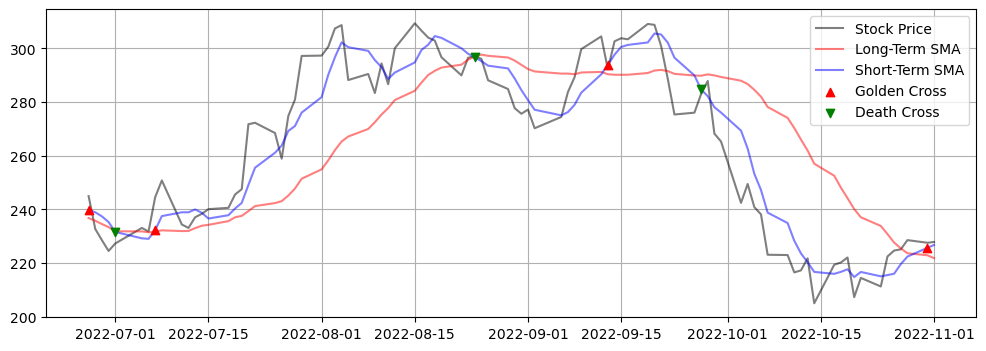

In [8]:
# the data frame `buy_sell_df` is just for plotting
# we don't need it for making decisions
buy_sell_df = stock_price.copy()
buy_sell_df["Buy"] = np.nan # use `np.nan` instead of `pd.NA`
buy_sell_df["Sell"] = np.nan
buy_sell_df.loc[golden, "Buy"] = short.loc[golden, "Close"]
buy_sell_df.loc[death, "Sell"] = short.loc[death, "Close"]

# plot the last 90 days
plt.figure(figsize=(12, 4))
plt.plot(stock_price[-num_days:], label="Stock Price", color="k", alpha=0.5)
plt.plot(long[-num_days:], label="Long-Term SMA", color="r", alpha=0.5)
plt.plot(short[-num_days:], label="Short-Term SMA", color="b", alpha=0.5)
plt.scatter(
    buy_sell_df[-num_days:].index, buy_sell_df[-num_days:]["Buy"], 
    marker="^", color="r", zorder=2,
    label="Golden Cross"
)
plt.scatter(
    buy_sell_df[-num_days:].index, buy_sell_df[-num_days:]["Sell"], 
    marker="v", color="g", zorder=2,
    label="Death Cross"
)
plt.legend()
plt.grid()
plt.show()

## Profit

Find the buying and selling dates starting from a given date, say 2022-06-27:

In [9]:
start_date = "2022-06-27"
buy_dates = golden[golden >= start_date]
sell_dates = death[death >= start_date]

# if we need to sell first, then ignore the first selling date 
# since we don't have any shares 
if buy_dates[0] > sell_dates[0]:
    sell_dates = sell_dates[1:]

If you buy a certain amount of shares and then sell it later, then the **percentage change** is given by 

$$
\text{Percentage} = \frac{\text{Selling Price} - \text{Buying Price}}{\text{Buying Price}}
$$

In [10]:
buy = stock_price.loc[buy_dates, "Close"].to_numpy()
sell = stock_price.loc[sell_dates, "Close"].to_numpy()

# buying and selling dates should come in pairs 
# except that there may be one more buying date in the end
assert len(buy) == len(sell) or len(buy) == len(sell) + 1

# don't buy
if len(buy) == len(sell) + 1:
    buy = buy[:-1]
    
# an array of percentage profit
pct = (sell - buy) / buy

pct

array([-0.07209155,  0.21490402, -0.03145861])

In this case, the array of percentage changes only has one element since we have seen in the figure that we only need to buy and sell once.

Suppose that you investigate $x$ dollars (**capital principal**), and you buy and sell $n$ times. The percentage change of the $i$-th trade is denoted by $p_i$. Then the final amount of money you will have is

$$
x (1 + p_1) (1 + p_2) \cdots (1 + p_n)
$$

Hence, the profit is 

$$
\text{Profit} = x (1 + p_1) (1 + p_2) \cdots (1 + p_n) - x
$$

If you investigate 100 dollars, then you will gain:

In [11]:
# capital principal
capital = 100

# total amount
total = capital * np.prod(1 + pct)

# profit/gain
profit = total - capital

profit

9.185579844095642

Hence, the profit rate is:

In [12]:
print(f"Profit rate: {profit:.2f}%")

Profit rate: 9.19%
